<a href="https://colab.research.google.com/github/davrodrod/algoritmosIA/blob/master/AtaquesAdversarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Fuente https://www.youtube.com/watch?v=JoQx39CoXW8

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

In [0]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [0]:
iv3 = InceptionV3()

In [6]:
iv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [25]:
from keras.preprocessing import image

# Se requiere preprocesar estos datos para pasárselo como entrada al modelo Inceptionve
# En primero lugar tiene que tener 299 x 299 pixeles
x = image.img_to_array(image.load_img('cerveza.png', target_size=(299,299)))

print(x.shape)

# Cada pixel tiene valores entre 0 y 255 el modelo espera valores entre -1, 1
# Se modifica el rango de valores
x /= 255
x -= 0.5
x *= 2

# Por último la red requiere un tensor de 4 dimensiones en lugar de 3. La primera
# dimensión hace referencia al tamaño del lote, para enviar, por ejemplo, 30 imágenes.
# Se añade una dimensión aunque sólo enviaremos una imagen

x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])

y = iv3.predict(x)

# Devuelve 1x1000 porque es sólo una foto y sale la probabilidad en cada una de 
# las 1000 categorías que tiene el modelo
print(y.shape)

# Con decode_predictions se mapea cada salida con el nombre de la clase correspondiente
# Además también las muestra ordenadas por lo que la primera será la mas probable

decode_predictions(y)

(299, 299, 3)
(1, 1000)


[[('n02823750', 'beer_glass', 0.9238261),
  ('n04357314', 'sunscreen', 0.00454328),
  ('n02783161', 'ballpoint', 0.002355664),
  ('n04116512', 'rubber_eraser', 0.0020016127),
  ('n03602883', 'joystick', 0.0017787362)]]

## Ataques Adversarios

El objetivo es engañar a la red. Que prediga que la imagen es otra cosa, la que nosotros le indiquemos, pero que un humano siga viendo una cerveza

Se realiza un proceso de optimización sobre la imagen de entrada, se modifican los píxeles para que la probabilidad de una clase se maximice. Por ejemplo la clase limón.

In [36]:
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

print(out_layer)

# Queremos que la red prediga que la imagen es un limón que corresponde con la
# categoría 951

target_class = 951

# Qué tiene que maximizar? la probabilidad de esa clase
loss = out_layer[0, target_class]

# Se requiere encontrar el gradiente entre el error y los parámetros a cambiar
grad = K.gradients(loss, inp_layer)[0]

# Función iterativa para que poco a poco se vaya computando el gradiente
# Keras tiene diferente modo de funcionar si estás entrenando o testeando y eso 
# se especifica con el parámetro k.learning_phase
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

adv = np.copy(x)

cost = 0.0

while cost < 0.95:
  #Ponemos K.learning_phase a 0 para indicar que estamos en modo test  o de pruebas
  gr, cost = optimize_gradient([adv, 0])

  # Se le suma ese gradiente a nuestra imagen
  adv += gr

  print("Target cost: ", cost)

Tensor("predictions_1/Softmax:0", shape=(None, 1000), dtype=float32)
Target cost:  2.3100518e-05
Target cost:  2.3188008e-05
Target cost:  2.3274695e-05
Target cost:  2.3361697e-05
Target cost:  2.3447872e-05
Target cost:  2.3534452e-05
Target cost:  2.3621506e-05
Target cost:  2.3709641e-05
Target cost:  2.3798686e-05
Target cost:  2.388802e-05
Target cost:  2.397793e-05
Target cost:  2.40688e-05
Target cost:  2.4160641e-05
Target cost:  2.425263e-05
Target cost:  2.4345143e-05
Target cost:  2.443874e-05
Target cost:  2.4533414e-05
Target cost:  2.4628476e-05
Target cost:  2.4724317e-05
Target cost:  2.4820827e-05
Target cost:  2.4916952e-05
Target cost:  2.5012852e-05
Target cost:  2.51099e-05
Target cost:  2.5206851e-05
Target cost:  2.530431e-05
Target cost:  2.5401734e-05
Target cost:  2.5499272e-05
Target cost:  2.5597901e-05
Target cost:  2.5697058e-05
Target cost:  2.5797344e-05
Target cost:  2.589851e-05
Target cost:  2.6001042e-05
Target cost:  2.6106463e-05
Target cost:  2.6

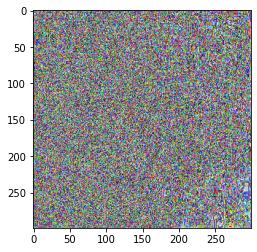

In [38]:
# Ahora se realiza el procesado inverso para pasar a valores
# entre 0 y 255

adv /= 2
adv += 0.5
adv *= 255

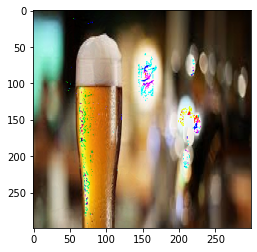

In [39]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [47]:
# Se ve que la imagen sigue siendo una cerveza pero se observan unos puntitos peceptibles al ojo humano
# que podrían indicar que la imagen se ha hackeado

# Para evitar esto hay que hacer dos cosas, lo que ya hemos hecho de maximizar la probabilidad de 
# una clase, pero por otro lado minimizar la perturbación de la imagen original. Para esto
# solo hay que indicar que la manipulación de los píxeles no excedan un umbral

inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

print(out_layer)

# Queremos que la red prediga que la imagen es un limón que corresponde con la
# categoría 951

target_class = 951

# Qué tiene que maximizar? la probabilidad de esa clase
loss = out_layer[0, target_class]

# Se requiere encontrar el gradiente entre el error y los parámetros a cambiar
grad = K.gradients(loss, inp_layer)[0]

# Función iterativa para que poco a poco se vaya computando el gradiente
# Keras tiene diferente modo de funcionar si estás entrenando o testeando y eso 
# se especifica con el parámetro k.learning_phase
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

adv = np.copy(x)

#Umbrales de manipulación de los píxeles
pert = 0.01
max_pert = x + pert
min_pert = x - pert

cost = 0.0

while cost < 0.95:
  #Ponemos K.learning_phase a 0 para indicar que estamos en modo test  o de pruebas
  gr, cost = optimize_gradient([adv, 0])

  # Se le suma ese gradiente a nuestra imagen
  adv += gr
  #El clip satura no permitiendo pasar de estos valores
  adv = np.clip(adv, min_pert, max_pert)
  # También se satura entre -1 y 1 para que no pase de esos límites
  adv = np.clip(adv, -1,1)

  print("Target cost: ", cost)

hacked = np.copy(adv)

Tensor("predictions_1/Softmax:0", shape=(None, 1000), dtype=float32)
Target cost:  2.3100518e-05
Target cost:  2.3187435e-05
Target cost:  2.3273797e-05
Target cost:  2.3360222e-05
Target cost:  2.344609e-05
Target cost:  2.3532022e-05
Target cost:  2.361858e-05
Target cost:  2.370622e-05
Target cost:  2.3794613e-05
Target cost:  2.3883536e-05
Target cost:  2.3972922e-05
Target cost:  2.4063274e-05
Target cost:  2.415455e-05
Target cost:  2.4246303e-05
Target cost:  2.4338065e-05
Target cost:  2.443108e-05
Target cost:  2.4525165e-05
Target cost:  2.461956e-05
Target cost:  2.4714745e-05
Target cost:  2.4810859e-05
Target cost:  2.4906325e-05
Target cost:  2.5001556e-05
Target cost:  2.5097572e-05
Target cost:  2.5194098e-05
Target cost:  2.5290812e-05
Target cost:  2.5387642e-05
Target cost:  2.5484494e-05
Target cost:  2.5582056e-05
Target cost:  2.56807e-05
Target cost:  2.5780231e-05
Target cost:  2.5880612e-05
Target cost:  2.59823e-05
Target cost:  2.6086047e-05
Target cost:  2.6

In [0]:
# Ahora se realiza el procesado inverso para pasar a valores
# entre 0 y 255

adv /= 2
adv += 0.5
adv *= 255

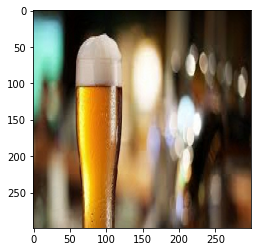

In [49]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()